# PROJECT 4: GROUP 3


# Paper A4: Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment vs Paper A1: Learning Fair Representations

The aim of the 2 papers is to formulate fairness as an optimization problem of finding a good representation of the
data with two competing goals: to encode the
data as well as possible, while simultaneously
obfuscating any information about membership in the sensitive group.


Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist – a term used to describe criminals who re-offend. There are dozens of these risk assessment algorithms in use. Many states have built their own assessments, and several academics have written tools. 

The Northpointe’s tool, called COMPAS (which stands for Correctional Offender Management Profiling for Alternative Sanctions), found that black defendants were far more likely than white defendants to be incorrectly judged to be at a higher risk of recidivism, while white defendants were more likely than black defendants to be incorrectly flagged as low risk.

Hence we use the Compas scores of 2 years and try to find a good representation of accuracy along with fairness and check if there is a discrimination or not

In [ ]:
import pandas as pd
import numpy as np
import pickle
import scipy.optimize as optim
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
#from __future__ import division
import os,sys
import numpy as np
from collections import defaultdict
from random import seed, shuffle
from collections import defaultdict
from copy import deepcopy
import numpy.core.multiarray
import cvxpy as cvx
import dccp
from dccp.problem import is_dccp
import traceback
import matplotlib.pylab as plt
import math
import copy

In [ ]:
!pip install dccp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dccp: filename=dccp-1.0.4-py3-none-any.whl size=7386 sha256=518fa5a6964f826d958b50c8fef07c8ea8b36030bd539ba6297aea3950ad2eb9
  Stored in directory: /root/.cache/pip/wheels/44/a0/2b/8944fc49959e6ae8cc9584719c236016c214a04baf6516e24d
Successfully built dccp


In [ ]:
import time
start_dm = time.time()

In [ ]:
#df = pd.read_csv('../data/compas-scores-two-years.csv')
df = pd.read_csv('compas-scores-two-years.csv')
df['length_of_stay']=df['c_jail_out'].apply(pd.to_datetime) - df['c_jail_in'].apply(pd.to_datetime)
df['length_of_stay']=df['length_of_stay'].dt.days
df['length_of_stay'] = df.length_of_stay.apply(lambda x:'greater than 100 days'  if x >100 else ('10-100 days' if x >10 else 'less than 10 days'))


In [ ]:
#Selecting features
features = ["age_cat", "race", "sex", "priors_count", "c_charge_degree","length_of_stay","decile_score"] 
cont_feature = ["priors_count"] 
sensitive_attributes = ["race"]

x_control = defaultdict(list)
data=df.copy()

# Data Filtering
idx = np.where((data['days_b_screening_arrest']<=30) & (data['days_b_screening_arrest']>=-30)
 & (data['is_recid']!=-1) & (data['c_charge_degree']!="O") & (data['score_text']!="N/A") &
 ((data['race']=="African-American") |(data['race']=="Caucasian")))
data=data.iloc[idx]


# convert class label 0 to -1
y = data['two_year_recid']
y[y==0] = -1

#adding intercept
intercept = np.ones(data.shape[0]).reshape(data.shape[0], 1)
X=pd.DataFrame(intercept, columns=['intercept'])


feature_names = []
for attr in features:
    vals = data[attr]
    if attr in cont_feature:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) #makes it into a 0 mean and variance 1
        vals = np.reshape(vals, (len(y), -1))
      
    else: 
        lb = preprocessing.LabelBinarizer()
        lb.fit(vals)
        vals = lb.transform(vals)

   
# Creating list called feature_names which contains column names
    # Checking continuous features
    if attr in cont_feature: 
        feature_names.append(attr)
    #Checking categorical features
    else: 
        # Binary features
        if vals.shape[1] == 1: 
            feature_names.append(attr)
        #Non Binary features - adding the names for every category
        else:
            for k in lb.classes_: 
                feature_names.append(attr + "_" + str(k))
    
    X[feature_names]=vals
    feature_names=[]


    
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1,shuffle=True)
x_control_train=x_train[sensitive_attributes]
x_control_test =x_test[sensitive_attributes]
feature_names= x_train.columns
x_train,x_test, y_train, y_test,x_control_train,x_control_test=x_train.values,x_test.values, y_train.values, y_test.values,x_control_train.values,x_control_test.values#converting everything to an array

#Making x_control_train and x_control_test into a dictionary 
x_control_train={sensitive_attributes[0]:x_control_train.flatten()}
x_control_test={sensitive_attributes[0]:x_control_test.flatten()}


# PAPER 4 : Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment

The overall goal of this algorithm is to build a fair classifier. In pratical scenarios when we are building a predictive model, a lot of festures are sensitive like gender, race, religion which can lead to a biased model. One example can be creating a predictive model to predict salaries of individuals and gender is included in the model. To avoid this, we add constraints to the model when we are optimizing. Under an ideal scenario, while building any type of model, our aim is to minimize the loss function. To make the model fair, we add contraints to the model, i.e we minimize the loss function while also making sure the contraints are met. In this algorithm those constraints were FPR and FNR. We cannot directly add the FPR abd FNR contraints to optimization funtion because they make the optimization problem non convex which are difficult to solve. Therefore we use a substitute which is the  covariance between the users’ sensitive attributes and the signed distance between the fea- ture vectors of misclassified users and the classifier decision boundary. The result in the algorithm is that we can find a balance which balances accuracy and fairness

In [ ]:
def train_model(x, y, x_control, EPS, cons_params,tau, mu):

    max_iters = 100 
    max_iter_dccp = 50  

    num_points, num_features = x.shape
    w = cvx.Variable(num_features) 
    np.random.seed(0)
    w.value = np.random.rand(x.shape[1])
    loss = cvx.sum(  cvx.logistic( cvx.multiply(-y, x*w) )  ) / num_points # Using Logistic Classifier
    
    #loss =  cvx.sum(cvx.logistic(x @ w) - cvx.multiply(y, x @ w) )
    constraints = []
    if cons_params is not None: 
 
        for attribute in cons_params["sensitive_attrs_to_cov_thresh"].keys():

            attribute_list = x_control_train[attribute]

            s_val_to_total = {param:{} for param in [0,1,2]} 
            s_val_to_avg = {param:{} for param in [0,1,2]}
            cons_sum_dict = {param:{} for param in [0,1,2]} 

            for val in set(attribute_list):
                s_val_to_total[0][val] = sum(x_control_train[attribute] == val)
                s_val_to_total[1][val] = sum(np.logical_and(x_control_train[attribute] == val, y_train == -1)) 
                s_val_to_total[2][val] = sum(np.logical_and(x_control_train[attribute] == val, y_train == +1))


            for param in [0,1,2]:
                s_val_to_avg[param][0] = s_val_to_total[param][1] / float(s_val_to_total[param][0] + s_val_to_total[param][1]) 
                s_val_to_avg[param][1] = 1.0 - s_val_to_avg[param][0] 


            for v in set(attribute_list):

                idx = x_control_train[attribute] == v                


                #################################################################
                # #DCCP constraints
                dist_bound_prod = cvx.multiply(y_train[idx], x_train[idx] * w) # y.f(x)

                cons_sum_dict[0][v] = cvx.sum( cvx.minimum(0, dist_bound_prod) ) * (s_val_to_avg[0][v] / len(x_train)) # avg misclassification distance from boundary
                cons_sum_dict[1][v] = cvx.sum( cvx.minimum(0, cvx.multiply( (1 - y_train[idx])/2.0, dist_bound_prod) ) ) * (s_val_to_avg[1][v] / sum(y_train == -1)) # avg false positive distance from boundary (only operates on the ground truth neg dataset)
                cons_sum_dict[2][v] = cvx.sum( cvx.minimum(0, cvx.multiply( (1 + y_train[idx])/2.0, dist_bound_prod) ) ) * (s_val_to_avg[2][v] / sum(y_train == +1)) # avg false negative distance from boundary
                #################################################################


            if cons_params["cons_type"] == 4:
                params = [1,2]
            elif cons_params["cons_type"] in [0,1,2]:
                params = [cons_params["cons_type"]]


            #################################################################
            for param in params:
                threshold = abs(cons_params["sensitive_attrs_to_cov_thresh"][attribute][param][1] - cons_params["sensitive_attrs_to_cov_thresh"][attribute][param][0])
                constraints.append( cons_sum_dict[param][1] <= cons_sum_dict[param][0]  + threshold )
                constraints.append( cons_sum_dict[param][1] >= cons_sum_dict[param][0]  - threshold )

            #################################################################
        
    if cons_params is not None:
        if cons_params.get("take_initial_sol") is None: # true by default
            take_initial_sol = True
        elif cons_params["take_initial_sol"] == False:
            take_initial_sol = False

        if take_initial_sol == True: # get the initial solution
            p = cvx.Problem(cvx.Minimize(loss), [])
            p.solve()
    prob = cvx.Problem(cvx.Minimize(loss), constraints)
    
    try:

        prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver='ECOS', verbose=False, 
            feastol=EPS, abstol=EPS, reltol=EPS,feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
            max_iters=max_iters, max_iter=max_iter_dccp)


    except:
        traceback.print_exc()
        sys.stdout.flush()
        sys.exit(1)


    # check that the fairness constraint is satisfied
    for f_c in constraints:
       # assert(f_c.value == True) # can comment this out if the solver fails too often, but make sure that the constraints are satisfied empirically. alternatively, consider increasing tau parameter
        pass
        

    w = np.array(w.value).flatten() # flatten converts it to a 1d array
    
    return w


In [ ]:
def sensitive_features(y_true, y_pred, x_control, sensitive_attributes, flag ):

    x_control_internal = deepcopy(x_control)

    data_dictionary = {}
    
    s = sensitive_attributes[0]

    s_vals = x_control_internal[s]
    for s_type in set(s_vals):
        data_dictionary[s_type] = {}
        y_true_local = y_true[s_vals==s_type]
        y_pred_local = y_pred[s_vals==s_type]

        acc = float(sum(y_true_local==y_pred_local)) / len(y_true_local)

        fp = sum(np.logical_and(y_true_local == -1.0, y_pred_local == +1.0))
        fn = sum(np.logical_and(y_true_local == +1.0, y_pred_local == -1.0)) 
        tp = sum(np.logical_and(y_true_local == +1.0, y_pred_local == +1.0)) 
        tn = sum(np.logical_and(y_true_local == -1.0, y_pred_local == -1.0)) 

        all_neg = sum(y_true_local == -1.0)
        all_pos = sum(y_true_local == +1.0)

        fpr = float(fp) / float(fp + tn)
        fnr = float(fn) / float(fn + tp)
        tpr = float(tp) / float(tp + fn)
        tnr = float(tn) / float(tn + fp)


        data_dictionary[s_type]["fp"] = fp
        data_dictionary[s_type]["fn"] = fn
        data_dictionary[s_type]["fpr"] = fpr
        data_dictionary[s_type]["fnr"] = fnr
        data_dictionary[s_type]["tpr"] = tpr
        data_dictionary[s_type]["tnr"] = tnr
        data_dictionary[s_type]["acc"] = (tp + tn) / (tp + tn + fp + fn)
        
    return data_dictionary



In [ ]:
def check_accuracy(x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):


    correct_answers = (y_train_predicted == y_train).astype(int) 
    train_score = float(sum(correct_answers)) / float(len(correct_answers))
    correct_answers_train = sum(correct_answers)
    
    
    correct_answers = (y_test_predicted == y_test).astype(int)
    test_score = float(sum(correct_answers)) / float(len(correct_answers))
    correct_answers_test = sum(correct_answers)

    return train_score, test_score, correct_answers_train, correct_answers_test


In [ ]:
def distance_boundary(w, x, s_attr_arr):

    distances_boundary = np.zeros(x.shape[0])
    if isinstance(w, dict): 
        for k in w.keys(): 
            d = np.dot(x, w[k])
            distances_boundary[s_attr_arr == k] = d[s_attr_arr == k]
    else: 
        distances_boundary = np.dot(x, w)
    return distances_boundary


In [ ]:
def classification_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attributes):

    s_val = sensitive_attributes[0] 

    distances_boundary_train = distance_boundary(w, x_train, x_control_train[s_val])
    distances_boundary_test = distance_boundary(w, x_test, x_control_test[s_val])

    all_class_labels_assigned_train = np.sign(distances_boundary_train)
    all_class_labels_assigned_test = np.sign(distances_boundary_test)

    train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy( x_train, y_train, x_test, y_test, all_class_labels_assigned_train, all_class_labels_assigned_test)

    data_dictionary_train = sensitive_features(y_train, all_class_labels_assigned_train, x_control_train, sensitive_attributes, False)
    
    data_dictionary_test = sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attributes, True)

    return train_score, test_score, data_dictionary_train, data_dictionary_test



In [ ]:
def classifier(EPS,tau,mu,cons_params):
    
    w = train_model(x_train, y_train, x_control_train, EPS, cons_params,tau, mu)
    
    train_score, test_score, data_dictionary_train, data_dictionary_test = classification_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attributes)
    
    return w, test_score, data_dictionary_test


In [ ]:
def accuracy_1(threshold, flag): 
    cons_type = 0 # No constraint 
    sensitive_attrs_to_cov_thresh = {"race": {0:{0:0, 1:threshold}, 1:{0:0, 1:0}, 2:{0:0, 1:0}}} # zero covariance threshold, means try to get the fairest solution
    cons_params = {"cons_type": cons_type, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}
    w_uncons, acc_cons, data_dictionary = classifier(EPS,tau,mu,cons_params)
    if flag == True:
        print("Unconstrained classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s     FPR.    FNR.    TNR.    TPR.   Accuracy")
        for key in data_dictionary:
            print("-----------------------------------------")
            print(str(key) + "     " + str(round(data_dictionary[key]['fpr'],2)) + "    " +str(round(data_dictionary[key]['fnr'],2)) + "    " +str(round(data_dictionary[key]['tnr'],2))+
              "    " +str(round(data_dictionary[key]['tpr'],2))+ "   "+ str(data_dictionary[key]['acc']))
            
        print()
    
    return (acc_cons, abs(data_dictionary[0]['fpr']-data_dictionary[1]['fpr']) , 
    abs(data_dictionary[0]['fnr']-data_dictionary[1]['fnr']),data_dictionary[0]['acc'],data_dictionary[1]['acc'])
    

In [ ]:
def accuracy_2(threshold, flag):
    cons_type = 1 # FPR constraint
    sensitive_attrs_to_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:threshold}, 2:{0:0, 1:0}}} # zero covariance threshold, means try to get the fairest solution
    cons_params = {"cons_type": cons_type, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}
    w_cons, acc_cons, data_dictionary  = classifier(EPS,tau,mu,cons_params)
    if flag == True:
        print("FPR constraint classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s     FPR.    FNR.    TNR.    TPR.   Accuracy")
        for key in data_dictionary:
            print("-----------------------------------------")
            print(str(key) + "     " + str(round(data_dictionary[key]['fpr'],2)) + "    " +str(round(data_dictionary[key]['fnr'],2)) + "    " +str(round(data_dictionary[key]['tnr'],2))+ "    " +str(round(data_dictionary[key]['tpr'],2))
            + "   "+ str(data_dictionary[key]['acc']))
        print()
    #print("accuracy cons",acc_cons)
    return (acc_cons, abs(data_dictionary[0]['fpr']-data_dictionary[1]['fpr']) , 
    abs(data_dictionary[0]['fnr']-data_dictionary[1]['fnr']),data_dictionary[0]['acc'],data_dictionary[1]['acc'])
    

In [ ]:
def accuracy_3(threshold, flag):
    cons_type = 2 # FNR constraint 
    sensitive_attrs_to_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:threshold}}} # zero covariance threshold, means try to get the fairest solution
    cons_params = {"cons_type": cons_type, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}
    w_cons, acc_cons, data_dictionary  = classifier(EPS,tau,mu,cons_params)
    if flag == True:
        print("FNR constraint classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s     FPR.    FNR.    TNR.    TPR.   Accuracy")
        for key in data_dictionary:
            print("-----------------------------------------")
            print(str(key) + "     " + str(round(data_dictionary[key]['fpr'],2)) + "    " +str(round(data_dictionary[key]['fnr'],2)) + "    " +str(round(data_dictionary[key]['tnr'],2))+
              "    " +str(round(data_dictionary[key]['tpr'],2))+ "   "+ str(data_dictionary[key]['acc']))
            
            print()
    
    return (acc_cons, abs(data_dictionary[0]['fpr']-data_dictionary[1]['fpr']) , 
    abs(data_dictionary[0]['fnr']-data_dictionary[1]['fnr']),data_dictionary[0]['acc'],data_dictionary[1]['acc'])
    

In [ ]:
def accuracy_4(threshold, flag):
    cons_type = 4 # FPR & FNR constraint 
    sensitive_attrs_to_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:threshold}, 2:{0:0, 1:threshold}}} # zero covariance threshold, means try to get the fairest solution
    cons_params = {"cons_type": cons_type, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}
    w_cons, acc_cons, data_dictionary  = classifier(EPS,tau,mu,cons_params)
    if flag == True:
        print("FPR & FNR constraint classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s     FPR.    FNR.    TNR.    TPR.   Accuracy")
        for key in data_dictionary:
            print("-----------------------------------------")
            print(str(key) + "     " + str(round(data_dictionary[key]['fpr'],2)) + "    " +str(round(data_dictionary[key]['fnr'],2)) + "    " +str(round(data_dictionary[key]['tnr'],2))+
              "    " +str(round(data_dictionary[key]['tpr'],2))+ "   "+ str(data_dictionary[key]['acc']))
            
            print()
    
    return (acc_cons, abs(data_dictionary[0]['fpr']-data_dictionary[1]['fpr']) , 
    abs(data_dictionary[0]['fnr']-data_dictionary[1]['fnr']),data_dictionary[0]['acc'],data_dictionary[1]['acc'])
    

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tau = 3.0
mu = 1.5
EPS = 1e-6

In [ ]:
threshold = 0
print("Threshold is " + str(threshold))
print("-----------------------------------------------------------------------------------------------")
print()
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_1(threshold, True)
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_2(threshold, True)
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_3(threshold, True)
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_4(threshold, True)
print()

Threshold is 0
-----------------------------------------------------------------------------------------------

Unconstrained classifier
Accuracy:  0.676
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.38    0.27    0.62    0.73   0.6719643992371265
-----------------------------------------
1     0.16    0.57    0.84    0.43   0.6819887429643527

FPR constraint classifier
Accuracy:  0.6669
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.27    0.39    0.73    0.61   0.6757787666878576
-----------------------------------------
1     0.32    0.4    0.68    0.6   0.6538461538461539

FNR constraint classifier
Accuracy:  0.6756
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.28    0.37    0.72    0.63   0.6745073108709473

-----------------------------------------
1     0.25    0.44    0.75    0.56   0.6772983114446529

FPR & FNR constraint classifie

In [ ]:
end_dm = time.time()
runtime_dm = (end_dm-start_dm)
print("Runtime of the code is  " + str(runtime_dm) + ' seconds')

Runtime of the code is  113.56461477279663 seconds


In [ ]:
tau = 3.0
mu = 1.5
EPS = 1e-6
cons_type7 = 0 # No constraint 
sensitive_attrs_to_cov_thresh7 = {"race": {0:{0:0, 1:threshold}, 1:{0:0, 1:0}, 2:{0:0, 1:0}}} # zero covariance threshold, means try to get the fairest solution
cons_params7 = {"cons_type": cons_type7, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh7}
w_uncons7, acc_cons7, data_dictionary7 = classifier(EPS,tau,mu,cons_params7)
data_dictionary7[1]['acc']
  

0.6819887429643527

## Analysis on varying the 'c' constant

In [ ]:
for threshold in range(0, 50, 5):
    threshold = threshold/1000
    print("Threshold is " + str(threshold))
    print("-----------------------------------------------------------------------------------------------")
    print()
    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_1(threshold, True)
    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_2(threshold, True)
    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_3(threshold, True)
    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_4(threshold, True)
    print()

Threshold is 0.0
-----------------------------------------------------------------------------------------------

Unconstrained classifier
Accuracy:  0.676
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.38    0.27    0.62    0.73   0.6719643992371265
-----------------------------------------
1     0.16    0.57    0.84    0.43   0.6819887429643527

FPR constraint classifier
Accuracy:  0.6669
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.27    0.39    0.73    0.61   0.6757787666878576
-----------------------------------------
1     0.32    0.4    0.68    0.6   0.6538461538461539

FNR constraint classifier
Accuracy:  0.6756
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.28    0.37    0.72    0.63   0.6745073108709473

-----------------------------------------
1     0.25    0.44    0.75    0.56   0.6772983114446529

FPR & FNR constraint classif

# PLOTS

### Constraints on FPR

In [ ]:
accuracy_dictionary = {}
diff_fpr_dictionary = {}
diff_fnr_dictionary = {}

for threshold in range(0, 50, 5):
    
    threshold = threshold/1000
    
    acc_cons, diff_fpr, diff_fnr = accuracy_2(threshold, False)
    diff_fpr_dictionary[threshold] = diff_fpr
    diff_fnr_dictionary[threshold] = diff_fnr
    accuracy_dictionary[threshold] = acc_cons

Constraints on FPR
Accuracy Plot vs Threshold


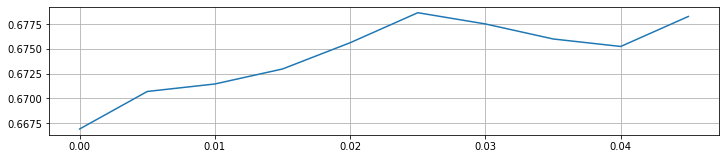

Differnce between FPR in Sensitive Variables Plot vs Threshold


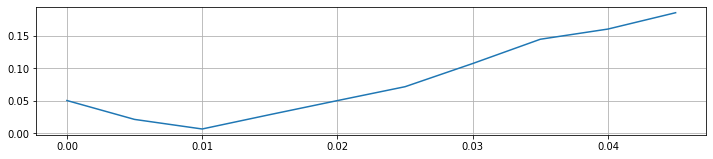

Differnce between FNR in Sensitive Variables Plot vs Threshold


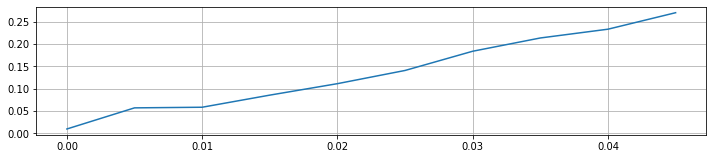

In [ ]:
import seaborn as sns
print("Constraints on FPR")
print("Accuracy Plot vs Threshold")
lists = sorted(accuracy_dictionary.items()) # sorted by key, return a list of tuples
fig=plt.figure(figsize=(12, 8))


x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot( 3, 1,1)
plt.plot(x, y)
plt.grid()
plt.show()

print("Differnce between FPR in Sensitive Variables Plot vs Threshold")
lists = sorted(diff_fpr_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot(3, 1,2)
plt.plot(x, y)
plt.grid()
plt.show()

print("Differnce between FNR in Sensitive Variables Plot vs Threshold")
lists = sorted(diff_fnr_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot( 3,1, 3)
plt.plot(x, y)
plt.grid()
plt.show()

#### **Here we see that as threshold(unfairness)  rises the accuracy increases. With rise of unfairness the fpr and well as fnr increases**

### Constraints on FNR

In [ ]:
accuracy_dictionary = {}
diff_fpr_dictionary = {}
diff_fnr_dictionary = {}

for threshold in range(0, 50, 5):
    
    threshold = threshold/1000
    
    acc_cons, diff_fpr, diff_fnr = accuracy_3(threshold, False)
    diff_fpr_dictionary[threshold] = diff_fpr
    diff_fnr_dictionary[threshold] = diff_fnr
    accuracy_dictionary[threshold] = acc_cons

Constraint of FNR
Accuracy Plot vs Threshold


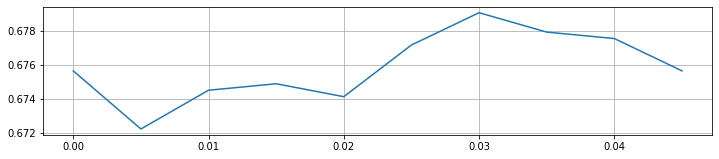

Differnce between FPR in Sensitive Variables Plot vs Threshold


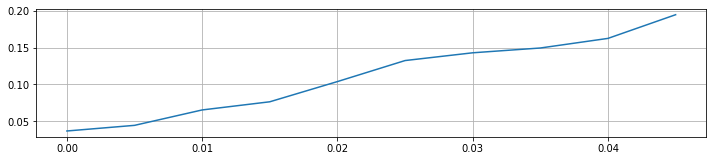

Differnce between FNR in Sensitive Variables Plot vs Threshold


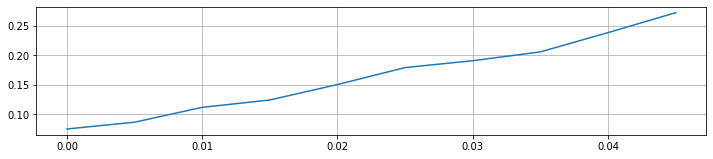

In [ ]:
print("Constraint of FNR")
print("Accuracy Plot vs Threshold")
lists = sorted(accuracy_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot( 3, 1,1)
plt.plot(x, y)
plt.grid()
plt.show()

print("Differnce between FPR in Sensitive Variables Plot vs Threshold")
lists = sorted(diff_fpr_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot(3, 1,2)
plt.plot(x, y)
plt.grid()
plt.show()

print("Differnce between FNR in Sensitive Variables Plot vs Threshold")
lists = sorted(diff_fnr_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot( 3,1, 3)
plt.plot(x, y)
plt.grid()
plt.show()

#### Here we see that as threshold(unfairness) rises the accuracy increases in first half but slightly decreases after threshold of 0.03. With rise of unfairness the fpr and well as fnr increases

### Constraints on FPR and FNR

In [ ]:
accuracy_dictionary = {}
diff_fpr_dictionary = {}
diff_fnr_dictionary = {}

for threshold in range(0, 50, 5):
    
    threshold = threshold/1000
    
    acc_cons, diff_fpr, diff_fnr = accuracy_4(threshold, False)
    diff_fpr_dictionary[threshold] = diff_fpr
    diff_fnr_dictionary[threshold] = diff_fnr
    accuracy_dictionary[threshold] = acc_cons

Constraints of FNR and FPR
Accuracy Plot vs Threshold


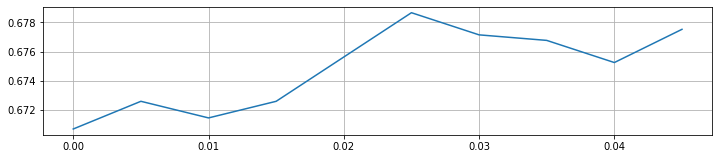

Differnce between FPR in Sensitive Variables Plot vs Threshold


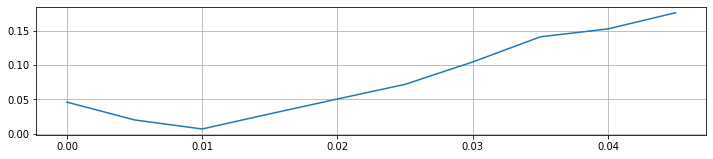

Differnce between FNR in Sensitive Variables Plot vs Threshold


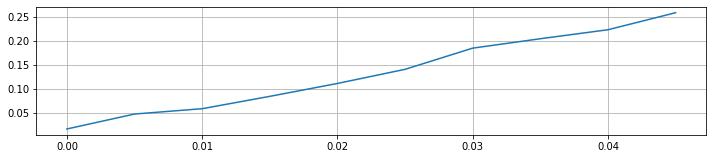

In [ ]:
print("Constraints of FNR and FPR")
print("Accuracy Plot vs Threshold")
lists = sorted(accuracy_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot( 3, 1,1)
plt.plot(x, y)
plt.grid()
plt.show()

print("Differnce between FPR in Sensitive Variables Plot vs Threshold")
lists = sorted(diff_fpr_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot(3, 1,2)
plt.plot(x, y)
plt.grid()
plt.show()

print("Differnce between FNR in Sensitive Variables Plot vs Threshold")
lists = sorted(diff_fnr_dictionary.items()) # sorted by key, return a list of tuples
plt.figure(figsize=(12, 8))
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.subplot(3, 1,3)
plt.plot(x, y)
plt.grid()
plt.show()

#### **Here also we see that as threshold(unfairness)  rises the accuracy increases. With rise of unfairness the fpr and well as fnr increases**

# PAPER 1: Learning Fair Representations



This is a feature selection algorithm. Given data of x’s, y and a sensitive variable (in the case of Compas, race), our goal was to calculate shapely values using observed conditional probabilities and the set structure of the data to estimate marginal accuracy and discrimination trade-off if a target variable is eliminated from the x matrix.

To build the code we basically tried to translate the proofs in the appendix to code, and were able to successfully implement this algorithm.

We ran this algorithm on a set of five candidate variables, and determined, on the basis of a high discrimination coefficient, we could likely remove priors_count from training sets.

Following this prescription modeled a logistic regression problem on the edited data. We looked at train and test accuracy and found that Black and White accuracies were comparable, but African American test accuracies were about 3.5% lower than those of White group.

In [ ]:
#helper function testing environment::
def helper_data_cleaning(x):
    #This code subsets the dataframe to relevant fields for the purpose of this analysis
    df = x[x['race'].isin(['African-American','Caucasian'])]
    idx = np.where((df['days_b_screening_arrest']<=30) & (df['days_b_screening_arrest']>=-30) &
                   (df['is_recid']!=-1) & (df['c_charge_degree']!="O") & (df['score_text']!="N/A") &
                   ((df['race']=="African-American") |(df['race']=="Caucasian")))
    df = df.iloc[idx]
    df=df.filter(items=['raw_data', 'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out'])
    
    return df

def encoding_data(x):
    
    x['race'] = x['race'].apply(lambda x: 1 if x == "Caucasian" else 0)
    #print(x['race'])
    x['sex'] = x['sex'].apply(lambda x: 1 if x == "Female" else 0)
    
    df1 = x
    df1['length_of_stay']=df1['c_jail_out'].apply(pd.to_datetime) - df1['c_jail_in'].apply(pd.to_datetime)
    df1['length_of_stay']=df1['length_of_stay'].dt.days
    df1['length_of_stay'] = df1.length_of_stay.apply(lambda x: 2  if x >100 else (1 if x >10 else 0))
    df1['priors_count'] = df1['priors_count'].apply(lambda x: 0 if x == 0 else x)
    df1['priors_count'] = df1['priors_count'].apply(lambda x: 1 if (1 <= x <= 3) else x)
    df1['priors_count'] = df1['priors_count'].apply(lambda x: 2 if x > 3 else x)
    # Label Encoding 
    #df1['race'] = df1['race'].apply(lambda x: 1 if x == 'Caucasian' else 0, axis = 0)
    #df1['race'] = df1['race_2']
    #df1.loc[df1.race=='Caucasian']=1
    #df1.loc[df1.race=='African-American']=0

    categorical_variables = ['c_charge_degree','sex','age_cat','score_text','length_of_stay','race']
    for var in categorical_variables:
        df1[var] = df1[var].astype('category').cat.codes
    final_vars = ['sex','age_cat','race','priors_count','c_charge_degree','length_of_stay']
    df1 = df1[final_vars]
    y = x['two_year_recid']
    return y,df1

In [ ]:
#cleaning/prepping data
df_1 = helper_data_cleaning(df)
y, df_1 = encoding_data(df_1)

In [ ]:
def unique_information_coef(x, y):
    import itertools
    nrow = x.shape[0]
    x_shap = x.shape[1]
    z = np.concatenate((x,y), axis=1)
    
    #unique combinations of possible encodings
    unique_combo = []
    for r in z.T:
        unique_combo.append(np.unique(r).tolist())
    
    cartesian = list(itertools.product(*unique_combo))
    
    running_p = 0
    
    
    for possible in cartesian:
        #print(ff," ", possible)
        mutual_ct, r_1_ct, r_2_ct = 0,0,0
        mutual_ct = np.sum(np.all(possible == z, axis=1))
        r_1_ct = np.sum(np.all(possible[:x_shap] == z[:,:x_shap], axis=1))
        r_2_ct = np.sum(np.all(possible[x_shap:] == z[:,x_shap:], axis=1))
        
        #for row in z:
            #checking if joint
         #   if possible == row:
          #      mutual_ct = mutual_ct+1 
            #checking x
           # if possible[:x_shap]== z[:x_shap]:
            #    r_1_ct = r_1_ct +1
            #checking y
            #if possible[x_shap:]== z[x_shap:]:
             #   r_2_ct = r_2_ct +1
            
        
        #saving computation in the event there's a zero result
        if (mutual_ct == 0 or r_1_ct == 0 or r_2_ct == 0):
            intermed = 0
        else:
            mutual_p = mutual_ct/nrow
            pr1 = r_1_ct/nrow
            pr2 = r_2_ct/nrow
            intermed = mutual_p * np.log(mutual_p / pr1) / pr1
        running_p += abs(intermed)
        
        
    return running_p

def conditional_info_coef(x,y,c):
    import itertools
    nrow = x.shape[0]
    x_shap = x.shape[1]
    y_shap = y.shape[1]
    #print(x.shape,y.shape,c.shape)
    z = np.concatenate((y,x,c), axis=1)
    
    #unique combinations of possible encodings
    unique_combo = []
    for r in z.T:
        unique_combo.append(np.unique(r).tolist())
    
    cartesian = list(itertools.product(*unique_combo))
    
    running_p = 0
    
    
    for possible in cartesian:
        
        #print(ff," ", possible)
        mutual_ct, r_1_ct, r_2_ct, r_cond = 0,0,0,0
        mutual_ct = np.sum(np.all(possible == z, axis=1))
        # r_1_ct = np.sum(np.all(possible[:1] == z[:,:1], axis=1))
        # r_2_ct = np.sum(np.all(possible[1:-x_shap] == z[:,1:-x_shap], axis=1))
        r_1_ct = np.sum(np.all(possible[:y_shap] == z[:,:y_shap], axis=1))
        r_2_ct = np.sum(np.all(possible[y_shap:-x_shap] == z[:,y_shap:-x_shap], axis=1))
        cond_ct_num = np.sum(np.where((possible[:y_shap] == z[:,:y_shap]).all(axis=1) & (possible[-x_shap:] == z[:,-x_shap:]).all(axis=1)))
        cond_ct_den = np.sum(np.where((possible[-x_shap:] == z[:,-x_shap:]).all(axis=1)))
        if cond_ct_den == 0:
            r_cond = 0
        else:
            r_cond = cond_ct_num/cond_ct_den
       
            
        
        #saving computation in the event there's a zero result
        if (mutual_ct == 0 or r_1_ct == 0 or r_2_ct == 0 or r_cond ==0):
            intermed = 0
        else:
            mutual_p = mutual_ct/nrow
            pr1 = r_1_ct/nrow
            pr2 = r_2_ct/nrow
            intermed = mutual_p * np.log(mutual_p / pr2) / r_cond
    
        running_p += abs(intermed)
        
        
    return running_p

def powerset(seq):
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

In [ ]:
def shapelydiscrimination(x,y):
    
    features = list(x.columns)
    features = [ele for ele in features if ele != 'race'] #removing race from list of features over which we iterate
    nfeat = len(features)
    
    shapely_coeff = []
    
    #identifying a feature sequentially to exclude from infoset calc
    for i in range(nfeat):
        
        features_2 = features.copy()
        rem = features_2.pop(i) #removing a feature i programmatically
        pow_set = [elm for elm in powerset(features_2)] #generating powerset list of lists
        
        shapely_inter = 0 #for summing the shapelys
        #now, iterating over the subsets
        for subset in pow_set:
            s_len = len(subset)
            f_len = nfeat - 1 - len(subset)
            
            m_coefficient = math.factorial(s_len) * math.factorial(f_len) / math.factorial(nfeat) #coeff
            
            #inclusive discrimination metric
            inc_sub = subset.copy()
            inc_sub.append(rem)
            
            x_1 = np.array(x[inc_sub])
            #print("x:",)
            protected_attribute = np.array(x['race']).reshape(-1,1)
            #print(protected_attribute.shape)
            y_1 = np.array(y).reshape(-1,1)
            
            info_in_ = np.concatenate((x_1,protected_attribute), axis = 1)
            
            incl_a = unique_information_coef(info_in_,y_1)
            incl_b = unique_information_coef(x_1,protected_attribute)
            incl_c = conditional_info_coef(x_1,protected_attribute,y_1)
            
            incl = incl_a * incl_b * incl_c
            #call info right here
            
            #exclusive discrimination metric
            x_2 = np.array(x[subset])
            info_ex_ = np.concatenate((x_2,protected_attribute), axis = 1)
            excl_a = unique_information_coef(info_ex_,y_1)
            excl_b = unique_information_coef(x_2,protected_attribute)
            excl_c = conditional_info_coef(x_2,protected_attribute,y_1)
            excl = excl_a * excl_b * excl_c
            
            #call info right here
            marginal_discrimination = incl-excl
            #marginal = disc_incl - disc_excl
            #shapley_coeff[i] = shapley_coeff[i] + coef * marginal
            shapely_inter = shapely_inter + m_coefficient * marginal_discrimination
        shapely_coeff.append(shapely_inter)
       
    return shapely_coeff

def shapelyaccuracy(x,y):
    features = list(x.columns)
    features = [ele for ele in features if ele != 'race'] #removing race from list of features over which we iterate
    nfeat = len(features)
    
    shapely_coeff = []
    
    #identifying a feature sequentially to exclude from infoset calc
    for i in range(nfeat):
        
        features_2 = features.copy()
        rem = features_2.pop(i) #removing a feature i programmatically
        pow_set = [elm for elm in powerset(features_2)] #generating powerset list of lists
        
        shapely_inter = 0 #for summing the shapelys
        #now, iterating over the subsets
        for subset in pow_set:
            s_len = len(subset)
            f_len = nfeat - 1 - len(subset)
            
            m_coefficient = math.factorial(s_len) * math.factorial(f_len) / math.factorial(nfeat) #coeff
            
            #inclusive accuracy metric
            inc_sub = subset.copy()
            inc_sub.append(rem)
            inc_sub_diff = list(set(features)-set(inc_sub))
            x_1c = np.array(x[inc_sub_diff])
            x_1 = np.array(x[inc_sub])
           
            protected_attribute = np.array(x['race']).reshape(-1,1)
           
            y_1 = np.array(y).reshape(-1,1)
            
            c = np.concatenate((x_1c,protected_attribute), axis = 1)
            
            #print( "out2: ",get_conditional_info_coef(y_1,x_1,c))
            accuracy_inclusive = conditional_info_coef(x_1,y_1,c)
            #call info right here
            
            #exclusive accuracy metric
            x_2 = np.array(x[subset])
            excl_sub = features_2
            excl_sub_diff = list(set(features_2)-set(subset))
            x_2c = np.array(x[excl_sub_diff])
            d = np.concatenate((x_2c,protected_attribute), axis = 1)
            accuracy_exclusive = conditional_info_coef(x_2,y_1,d)
            
            #marginal accuracy by including
            marginal_acc = accuracy_inclusive - accuracy_exclusive
            shapely_inter = shapely_inter + m_coefficient * marginal_acc
            
        if shapely_inter> 0:
            shapely_coeff.append(shapely_inter)
    return shapely_coeff

In [ ]:
import time
start = time.time()
accuracy = shapelyaccuracy(df_1,y)
discrimination = shapelydiscrimination(df_1,y)
end = time.time()
print(end - start)

26.75325107574463


In [ ]:
features = list(df_1.columns)
features = [ele for ele in features if ele != 'race']
acc_disc_pretty = pd.DataFrame(list(zip(features,accuracy,discrimination)))
acc_disc_pretty.columns = ['variable','accuracy','discrimination']
print(acc_disc_pretty)
varlist_for_model = list(acc_disc_pretty['variable'])
varlist_for_model.remove('priors_count')
print(varlist_for_model)


          variable  accuracy  discrimination
0              sex  0.607707     5933.746182
1          age_cat  0.892485     8871.607730
2     priors_count  0.984446     9024.280430
3  c_charge_degree  0.730598     7155.980280
4   length_of_stay  0.668507     8352.821957
['sex', 'age_cat', 'c_charge_degree', 'length_of_stay']


# Logistic regression

We now remove variable with highest discrimination and are left with tolerble or unaviodable

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
df_m = df_1[varlist_for_model]
x_train, x_test, y_train, y_test = train_test_split(df_m, y, test_size=0.3, random_state=1,shuffle=True)
model = LogisticRegression()
model.fit(x_train,y_train)
y_hat = model.predict(x_test)
test_acc = accuracy_score(y_hat,y_test)
y_hat_train = model.predict(x_train)
train_acc = accuracy_score(y_hat_train,y_train)


In [ ]:
x_train = pd.merge(x_train, df_1, left_index=True, right_index=True)
x_train['pred'] = y_hat_train
x_train['act'] = y_train
x_test = pd.merge(x_test, df_1, left_index=True, right_index=True)
x_test['pred'] = y_hat
x_test['act'] = y_test

In [ ]:
x_train_c = x_train[x_train['race'] == 1]
x_test_c = x_test[x_test['race'] == 1]
x_train_nc = x_train[x_train['race'] == 0]
x_test_nc = x_test[x_test['race'] == 0]
White_train_acc = accuracy_score(x_train_c['pred'],x_train_c['act'])
Black_train_acc = accuracy_score(x_train_nc['pred'],x_train_nc['act'])
white_test_acc = accuracy_score(x_test_c['pred'],x_test_c['act'])
Black_test_acc = accuracy_score(x_test_nc['pred'],x_test_nc['act'])

In [ ]:


print("Race.          Train                      Test")
print("Overall.      ", train_acc,"     ",test_acc)
print("White(0)      ",White_train_acc,"     ",white_test_acc)
print("Black(1)      ",Black_train_acc,"     ",Black_test_acc)

Race.          Train                      Test
Overall.       0.5709258256632377       0.5555555555555556
White(0)       0.5740868366643694       0.5782208588957055
Black(1)       0.5688809629959876       0.5396995708154506


In [ ]:
# Overall confusion matrix
tn, fp, fn, tp = confusion_matrix(x_test['act'],x_test['pred']).ravel()
print("True Negative: ",tn," True Positive: ",tp," False Negative: ", fn,"False Positive: ",fp)
print('------------------------------')
print("FPR                            FNR")
print(fp/(fp+tp),'       ',fn/(fn+tn))

True Negative:  598  True Positive:  282  False Negative:  432 False Positive:  272
------------------------------
FPR                            FNR
0.49097472924187724         0.41941747572815535


In [ ]:
# Races confusion matrix
# White
w_tn, w_fp, w_fn, w_tp= confusion_matrix(x_test_c['act'],x_test_c['pred']).ravel()
#Black
b_tn, b_fp, b_fn, b_tp= confusion_matrix(x_test_nc['act'],x_test_nc['pred']).ravel()

#Print
print(print("Race.    FPR                            FNR"))
print("White(0)",'   ',w_fp/(w_fp+w_tp),'       ',w_fn/(w_fn+w_tn))
print("Black(1)",'   ',b_fp/(b_fp+b_tp),'       ',b_fn/(b_fn+b_tn))

Race.    FPR                            FNR
None
White(0)     0.5566037735849056         0.3568181818181818
Black(1)     0.4502923976608187         0.4661016949152542


# COMPARISON BETWEEN THE 2 PAPERS

From Paper A4

In [ ]:

threshold = 0
print("Threshold is " + str(threshold))
print("-----------------------------------------------------------------------------------------------")
print()
# Baseline
acc_cons_bas, diff_fpr_bas, diff_fnr_bas, acc_w_bas,acc_b_bas = accuracy_1(threshold, True)
# With constraint
acc_cons_fpr, diff_fpr_fpr, diff_fnr_fpr, acc_w_fpr,acc_b_fpr= accuracy_2(threshold, True)
acc_cons_fnr, diff_fpr_fnr, diff_fnr_fnr,acc_w_fnr,acc_b_fnr = accuracy_3(threshold, True)
acc_cons_fpr_fnr, diff_fpr_fpr_fnr, diff_fnr_fpr_fnr,acc_w_fpr_fnr,acc_b_fpr_fnr = accuracy_4(threshold, True)

Threshold is 0
-----------------------------------------------------------------------------------------------

Unconstrained classifier
Accuracy:  0.676
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.38    0.27    0.62    0.73   0.6719643992371265
-----------------------------------------
1     0.16    0.57    0.84    0.43   0.6819887429643527

FPR constraint classifier
Accuracy:  0.6669
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.27    0.39    0.73    0.61   0.6757787666878576
-----------------------------------------
1     0.32    0.4    0.68    0.6   0.6538461538461539

FNR constraint classifier
Accuracy:  0.6756
s     FPR.    FNR.    TNR.    TPR.   Accuracy
-----------------------------------------
0     0.28    0.37    0.72    0.63   0.6745073108709473

-----------------------------------------
1     0.25    0.44    0.75    0.56   0.6772983114446529

FPR & FNR constraint classifie

## Callibration

Text(0.5, 1.0, 'Calibration')

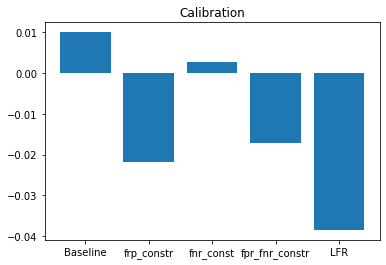

In [ ]:
#  Callibration

plt.bar(np.arange(5),[acc_b_bas-acc_w_bas,acc_b_fpr-acc_w_fpr,acc_b_fnr-acc_w_fnr,acc_b_fpr_fnr-acc_w_fpr_fnr,Black_test_acc-white_test_acc])
plt.xticks(np.arange(5),['Baseline','frp_constr','fnr_const','fpr_fnr_constr','LFR'])
plt.title("Calibration")

### Accuracy

Text(0.5, 1.0, 'Accuracy')

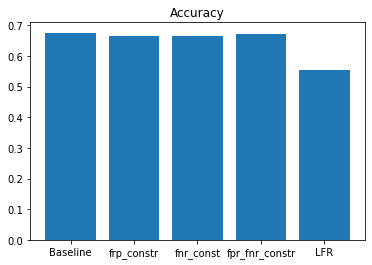

In [ ]:
# Accuracy
plt.bar(np.arange(5),[acc_cons_bas,acc_cons_fpr,acc_cons_fpr,acc_cons_fpr_fnr,test_acc])
plt.xticks(np.arange(5),['Baseline','frp_constr','fnr_const','fpr_fnr_constr','LFR'])
plt.title("Accuracy")

Text(0.5, 1.0, 'FPR')

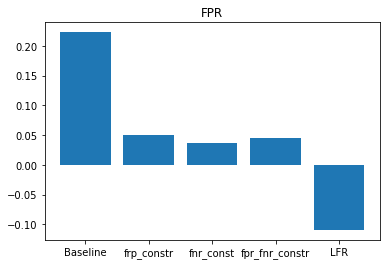

In [ ]:
# FPR
plt.bar(np.arange(5),[diff_fpr_bas,diff_fpr_fpr,diff_fpr_fnr,diff_fpr_fpr_fnr,w_fn/(w_fn+w_tn)-b_fn/(b_fn+b_tn)])
plt.xticks(np.arange(5),['Baseline','frp_constr','fnr_const','fpr_fnr_constr','LFR'])
plt.title("FPR").  # (black -white>)

Text(0.5, 1.0, 'FNR')

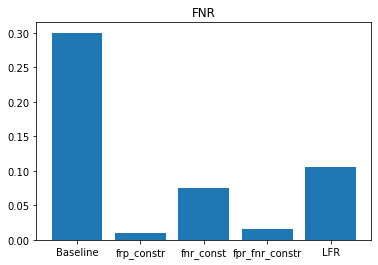

In [ ]:
# FNR
plt.bar(np.arange(5),[diff_fnr_bas,diff_fnr_fpr,diff_fnr_fnr,diff_fnr_fpr_fnr,w_fp/(w_fp+w_tp)-b_fp/(b_fp+b_tp)])
plt.xticks(np.arange(5),['Baseline','frp_constr','fnr_const','fpr_fnr_constr','LFR'])
plt.title("FNR")

# CONCLUSION:
1. We see that usually when unfairness rises accuracy increases. 
2. Paper A4 algorithms(Having fpr constraint,fnr constraint, fpr and fnr constraint) provides a better accuracy as well as better calibration than LFR algorithm<br>
3. We see fpr and fnr is lesser than the baseline models